In [1]:
#imports
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from random import random, randrange

from PIL import Image, ImageStat

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from torchsummary import summary

import dill as pkl


In [2]:
#hyperparameters
rng = np.random.default_rng(seed=42)
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 32 #32
lr = 0.001
num_epoch = 100

nch = 3
nker = 64
height = 100
width = 100

MIN_OFFSET = 0
MAX_OFFSET = 8
MIN_SPACING = 2
MAX_SPACING = 6
MIN_KNOWN_PIXELS = 144

device

device(type='cuda', index=0)

In [3]:
#helper functions

def imgtoarrays(image_array: np.ndarray, offset: tuple, spacing: tuple):
    if not isinstance(image_array, np.ndarray):
        raise TypeError("image_array must be a numpy array!")
    
    if image_array.ndim != 3 or image_array.shape[2] != 3:
        raise NotImplementedError("image_array must be a 3D numpy array whose 3rd dimension is of size 3")
    
    # Check for conversion to int (would raise ValueError anyway, but we will write a nice error message)
    try:
        offset = [int(o) for o in offset]
        spacing = [int(s) for s in spacing]
    except ValueError as e:
        raise ValueError(f"Could not convert entries in offset and spacing ({offset} and {spacing}) to int! Error: {e}")
    
    for i, o in enumerate(offset):
        if o < MIN_OFFSET or o > MAX_OFFSET:
            raise ValueError(f"Value in offset[{i}] must be in [{MIN_OFFSET}, {MAX_OFFSET}] but is {o}")
    
    for i, s in enumerate(spacing):
        if s < MIN_SPACING or s > MAX_SPACING:
            raise ValueError(f"Value in spacing[{i}] must be in [{MIN_SPACING}, {MAX_SPACING}] but is {s}")
    
    # Change dimensions from (H, W, C) to PyTorch's (C, H, W)
    image_array = np.transpose(image_array, (2, 0, 1))
    
    # Create known_array
    known_array = np.zeros_like(image_array)
    known_array[:, offset[1]::spacing[1], offset[0]::spacing[0]] = 1
    
    known_pixels = np.sum(known_array[0], dtype=np.uint32)
    if known_pixels < MIN_KNOWN_PIXELS:
        raise ValueError(f"The number of known pixels after removing must be at "
                         f"least {MIN_KNOWN_PIXELS} but is {known_pixels}")
    
    # Create target_array - don't forget to use .copy(), otherwise target_array
    # and image_array might point to the same array!
    target_array = image_array[known_array == 0].copy()
    
    # Use image_array as input_array
    image_array[known_array == 0] = -1 #0
    
    return image_array, known_array, target_array


def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))
    
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

In [4]:
#data paths
path = './training'

ckpt_dir = './ckpt'
result_dir_train = './train_img'
result_dir_valid = './valid_img'

files = glob.glob(os.path.join(path, "**", "*.jpg"), recursive=True)

train_files = files[:(len(files)*9)//10]
valid_files = files[(len(files)*9)//10:]

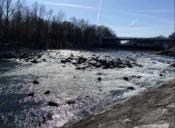

In [15]:
with Image.open(train_files[randrange(0,len(train_files))]) as img:
  display(img)

In [17]:
#datasets
def collate_fn(batch: list):
    input_arrays = [sample[0] for sample in batch]

    maxX = np.max([seq.shape[1] for seq in input_arrays])
    maxY = np.max([seq.shape[2] for seq in input_arrays])

    n_feature_channels = input_arrays[0].shape[0]

    #stack input arrays
    stacked_input_arrays = torch.zeros(size=(len(input_arrays), n_feature_channels, maxX, maxY), dtype=torch.float32)
    for i, sequence in enumerate(input_arrays):
        stacked_input_arrays[i, :len(sequence), :] = torch.from_numpy(sequence)

    #stack known arrays
    known_arrays = [sample[1] for sample in batch]

    stacked_known_arrays = torch.zeros(size=(len(known_arrays), n_feature_channels, maxX, maxY), dtype=torch.float32)
    for i, sequence in enumerate(known_arrays):
        stacked_known_arrays[i, :len(sequence), :] = torch.from_numpy(sequence)

    #stack ground truth images
    gt_arrays = [sample[2] for sample in batch]

    stacked_gt_arrays = torch.zeros(size=(len(gt_arrays), n_feature_channels, maxX, maxY), dtype=torch.float32)
    for i, sequence in enumerate(gt_arrays):
        stacked_gt_arrays[i, :len(sequence),] = torch.from_numpy(sequence)
    
    return stacked_input_arrays, stacked_known_arrays, stacked_gt_arrays

class ImageDataset(Dataset):
    def __init__(self, img_files, transform=None):
        self.img_files = img_files
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        image = Image.open(self.img_files[idx]).convert('RGB')

        #augumentations
        if self.transform:
            image = self.transform(image)

        image = np.array(image)

        #normalization
        image = interval_mapping(image, 0, 255, 0.0, 1.0)


        #reverse normalization
        #img = interval_mapping(image, 0.0, 1.0, 0, 255).astype('uint8')

        offset = (randrange(MIN_OFFSET, MAX_OFFSET), randrange(MIN_OFFSET, MAX_OFFSET))
        spacing = (randrange(MIN_SPACING, MAX_SPACING), randrange(MIN_SPACING, MAX_SPACING))

        input_array, known_array, _ = imgtoarrays(image.copy(), offset, spacing)

        return input_array, known_array, np.transpose(image, (2, 0, 1))


#augementations
trainTransforms = transforms.Compose([transforms.RandomResizedCrop(size=(height, width)), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()])
valTransforms = transforms.Compose([transforms.CenterCrop(size=(height, width))])

train_dataset = ImageDataset(train_files, trainTransforms)
valid_dataset = ImageDataset(valid_files, valTransforms)


train_set = DataLoader(dataset=train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      collate_fn=collate_fn,
                      pin_memory=True)

valid_set = DataLoader(dataset=valid_dataset,
                      batch_size=batch_size,
                      collate_fn=collate_fn,
                      pin_memory=True)

num_data_train = len(train_dataset)
num_data_val = len(valid_dataset)

In [18]:
num_data_train

163017

torch.Size([32, 3, 100, 100])
torch.Size([32, 3, 100, 100])
torch.Size([32, 3, 100, 100])


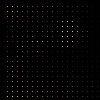

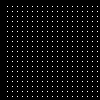

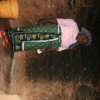

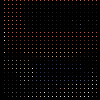

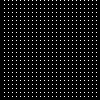

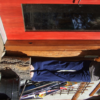

In [20]:
outputs = list(next(iter(train_set)))

print(outputs[0].shape)
print(outputs[1].shape)
print(outputs[2].shape)

for i in range(2):
  for a in outputs:
    img = a.numpy()[i]
    img = interval_mapping(img, 0.0, 1.0, 0, 255).astype('uint8')
    display(Image.fromarray(img.T, 'RGB'))

In [38]:
#model
class CBR_layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, norm="bnorm", relu=0.0):
        super().__init__()

        layers = []
        layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                             kernel_size=kernel_size, stride=stride, padding=padding,
                             bias=bias)]

        if not norm is None:
            if norm == "bnorm":
                layers += [nn.BatchNorm2d(num_features=out_channels)]
            elif norm == "inorm":
                layers += [nn.InstanceNorm2d(num_features=out_channels)]

        if not relu is None and relu >= 0.0:
            layers += [nn.ReLU() if relu == 0 else nn.LeakyReLU(relu)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)


class UNet(nn.Module):
    def __init__(self, nch=3, nker=64, norm="bnorm"):
        super(UNet, self).__init__()

        self.enc1_1 = CBR_layer(in_channels=nch, out_channels=1 * nker, norm=norm)
        self.enc1_2 = CBR_layer(in_channels=1 * nker, out_channels=1 * nker, norm=norm)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR_layer(in_channels=nker, out_channels=2 * nker, norm=norm)
        self.enc2_2 = CBR_layer(in_channels=2 * nker, out_channels=2 * nker, norm=norm)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR_layer(in_channels=2 * nker, out_channels=4 * nker, norm=norm)
        self.enc3_2 = CBR_layer(in_channels=4 * nker, out_channels=4 * nker, norm=norm)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR_layer(in_channels=4 * nker, out_channels=8 * nker, norm=norm)
        self.enc4_2 = CBR_layer(in_channels=8 * nker, out_channels=8 * nker, norm=norm)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR_layer(in_channels=8 * nker, out_channels=16 * nker, norm=norm)


        self.dec5_1 = CBR_layer(in_channels=16 * nker, out_channels=8 * nker, norm=norm)

        self.unpool4 = nn.ConvTranspose2d(in_channels=8 * nker, out_channels=8 * nker,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR_layer(in_channels=2 * 8 * nker, out_channels=8 * nker, norm=norm)
        self.dec4_1 = CBR_layer(in_channels=8 * nker, out_channels=4 * nker, norm=norm)

        self.unpool3 = nn.ConvTranspose2d(in_channels=4 * nker, out_channels=4 * nker,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR_layer(in_channels=2 * 4 * nker, out_channels=4 * nker, norm=norm)
        self.dec3_1 = CBR_layer(in_channels=4 * nker, out_channels=2 * nker, norm=norm)

        self.unpool2 = nn.ConvTranspose2d(in_channels=2 * nker, out_channels=2 * nker,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR_layer(in_channels=2 * 2 * nker, out_channels=2 * nker, norm=norm)
        self.dec2_1 = CBR_layer(in_channels=2 * nker, out_channels=1 * nker, norm=norm)

        self.unpool1 = nn.ConvTranspose2d(in_channels=1 * nker, out_channels=1 * nker,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR_layer(in_channels=2 * 1 * nker, out_channels=1 * nker, norm=norm)
        self.dec1_1 = CBR_layer(in_channels=1 * nker, out_channels=1 * nker, norm=norm)

        self.fc = nn.Conv2d(in_channels=1 * nker, out_channels=nch, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        unpool3 = nn.Upsample(size=(25, 25), mode='bilinear')(unpool3)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)#x + self.fc(dec1_1)

        x = torch.clip(x, min=0., max=1.)

        return x

In [47]:
net = UNet(nch=nch, nker=nker).to(device)

fn_loss = nn.MSELoss().to(device)
valid_loss = RMSELoss().to(device)


optim = torch.optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)
st_epoch = 0


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

#summary(net, (3, 100, 100))
st_epoch

23

In [23]:
optim.param_groups[0]['lr'] = 0.0001

In [ ]:
#training MSE image, valid RMSE pixel

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

cmap = None

for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train()
    loss_mse = []

    for batch, data in enumerate(train_set, 1):
        # forward pass
        input = data[0].to(device)
        label = data[2].to(device)
        mask = data[1]

        output = net(input)

        # backward pass
        optim.zero_grad()

        # inv_mask = torch.logical_not(mask).to(device)
        # loss = fn_loss((output*inv_mask)*255, (label*inv_mask)*255)
        loss = fn_loss(output, label)
        loss.backward()

        optim.step()

        loss_mse += [loss.item()]

        if batch % 20 == 0 or batch == 1:
            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | MSE LOSS %.4f / BATCH LOSS %.4f" % (epoch, num_epoch, batch, num_batch_train, np.mean(loss_mse), loss_mse[-1]))

        if batch % 100 == 0:
          label = interval_mapping(label.cpu().detach().numpy()[0], 0.0, 1.0, 0, 255).astype('uint8')
          input = interval_mapping(input.cpu().detach().numpy()[0], 0.0, 1.0, 0, 255).astype('uint8')
          output = interval_mapping(output.cpu().detach().numpy()[0], 0.0, 1.0, 0, 255).astype('uint8')

          id = num_batch_train * (epoch - 1) + batch

          plt.imsave(os.path.join(result_dir_train, '%04d_label.png' % id), label.T.squeeze(), cmap=cmap)
          plt.imsave(os.path.join(result_dir_train, '%04d_input.png' % id), input.T.squeeze(), cmap=cmap)
          plt.imsave(os.path.join(result_dir_train, '%04d_output.png' % id), output.T.squeeze(), cmap=cmap)

        if batch % 500 == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)
    scheduler.step()
    save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)


    with torch.no_grad():
        net.eval()
        loss_mse = []

        for batch, data in enumerate(valid_set, 1):
            # forward pass
            input = data[0].to(device)
            label = data[2].to(device)
            mask = data[1]

            output = net(input)

            inv_mask = torch.logical_not(mask).to(device)
            loss = valid_loss(output*inv_mask, label*inv_mask)*255

            loss_mse += [loss.item()]

            if batch % 20 == 0:
                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | RMSE LOSS %.4f / BATCH LOSS %.4f" % (epoch, num_epoch, batch, num_batch_val, np.mean(loss_mse), loss_mse[-1]))

            if batch % 100 == 0:

              label = interval_mapping(label.cpu().detach().numpy()[0], 0.0, 1.0, 0, 255).astype('uint8')
              input = interval_mapping(input.cpu().detach().numpy()[0], 0.0, 1.0, 0, 255).astype('uint8')
              output = interval_mapping(output.cpu().detach().numpy()[0], 0.0, 1.0, 0, 255).astype('uint8')

              id = num_batch_train * (epoch - 1) + batch

              plt.imsave(os.path.join(result_dir_valid, '%04d_label.png' % id), label.T.squeeze(), cmap=cmap)
              plt.imsave(os.path.join(result_dir_valid, '%04d_input.png' % id), input.T.squeeze(), cmap=cmap)
              plt.imsave(os.path.join(result_dir_valid, '%04d_output.png' % id), output.T.squeeze(), cmap=cmap)

In [ ]:
test_path = './test/inputs.pkl'

with open(test_path,"rb") as fh:
    test_data = pkl.load(fh)

n_samples = len(test_data["input_arrays"])

predictions = []
pixpred = []
with torch.no_grad():
    net.eval()
    for sample_i in range(n_samples):
        input_array = test_data["input_arrays"][sample_i].astype(np.float32)
        input_array = interval_mapping(input_array, 0, 255, 0.0, 1.0)

        known_array = test_data["known_arrays"][sample_i].astype(np.float32)

        input_array[known_array == 0] = -1

        inputs = input_array[None]
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        prediction = net(inputs)
        prediction = interval_mapping(prediction.cpu().detach().numpy(), 0.0, 1.0, 0, 255).astype('uint8')
        prediction = np.clip(prediction.squeeze(), a_min=0, a_max=255)
        pix = np.asarray(prediction[known_array == 0].copy(), dtype=np.uint8)
        prediction = np.asarray(prediction, dtype=np.uint8)

        predictions.append(prediction)
        pixpred.append(pix)

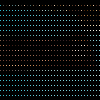

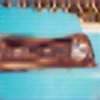

8663

In [11]:
display(Image.fromarray(test_data["input_arrays"][0].squeeze().T, 'RGB'))
display(Image.fromarray(predictions[0].T, 'RGB'))
n_samples

In [12]:
with open('./preds.pkl', 'wb') as handle:
    pkl.dump(pixpred, handle, protocol=pkl.HIGHEST_PROTOCOL)